In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import seaborn as sns

In [2]:
data = pd.read_table('en.openfoodfacts.org.products.tsv', low_memory = False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


# Data Preparation

We see that we have more than 350'000 products. However, some of them do not have informations on the nutriments. Since we want to study the nutriments of the products, we drop all that do not have such informations. Similarily, we drop all the products that do not have a name.

In [4]:
data.dropna(subset = ['energy_100g', 'product_name'], inplace = True)

We assume that if we have for example a null-value in the sugar column, then it means that the desired product 
does not contain sugar. Therefore, we fill the null-values with zeroes in the nutriment columns.

In [5]:
columns = pd.Series(data.columns)
nutriment_columns = []
for i in range(columns.size):
    if columns.str.contains('_100g')[i] == True :
        nutriment_columns.append(columns[i])
data[nutriment_columns] = data[nutriment_columns].fillna(0)   

We made sure that we do not drop the informations about the nutriments. However, there are still a lot of null-values in the data frame. We will delete the columns that have almost only null-values. In addition, we delete also some columns that do not seem interesting for our purposes.

In [6]:
data.dropna(thresh = 200000, axis = 1, inplace = True)
data.drop(['code', 'url', 'creator', 'created_t', 'last_modified_t', 'brands_tags',
          'countries', 'countries_tags', 'additives_n', 'ingredients_from_palm_oil_n',
          'ingredients_that_may_be_from_palm_oil_n', 'states', 'states_tags', 'states_en',
          'nutrition_grade_fr', 'additives', 'serving_size'], axis = 1, inplace = True)
data.set_index('product_name', inplace = True)

We have now almost no null-values left. For the remaining few articles that do not have any informations in the brand or ingredient_text column, we just add 'Information not available'. We finally have a data frame with no null-values. 

In [7]:
final_missing_values = ['brands', 'countries_en', 'ingredients_text']
for i in final_missing_values :
    data[i].fillna(value = 'Information not available', inplace = True)
data.dropna(inplace = True)

However, after taking a closer look, we can see that there are still a lot of problems. For example, duplicated values that only differ in the 'created_datetime' column. Or also products that have ridiculously high energetic values (I don't want to drink a soup with more than 14000 kJ per 100g). We want to deal at least with those problems. Unfortunately, there will probably remain incorrect values in the data frame. But, we assume that those are in a minority or lie in columns that we are not really interested in.

In [8]:
data.drop_duplicates(subset = data.iloc[:,2:], inplace = True)
filter = data['energy_100g'] < 4000 # the choice of 4000 kJ comes from the fact that oil has around 3600 kJ.
data = data[filter]
macronutritents = ['fat_100g', 'carbohydrates_100g', 'proteins_100g']
for i in macronutritents:
    filter = (data[i] >= 0) & (data[i] <= 100) # we want that the values in those columns lie in [0,100], 
    data = data[filter] # because  it corresponds to a percentage.

We take a look at our dataset:

In [9]:
data.head()

,created_datetime,last_modified_datetime,brands,countries_en,ingredients_text,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
product_name,,,,,,,,,,,,,,,,,,,,,
Banana Chips Sweetened (Whole),2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Information not available,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",2243.0,0.0,28.57,28.57,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,14.0,0.0,0.0
Peanuts,2017-03-09T14:32:37Z,2017-03-09T14:32:37Z,Torn & Glasser,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",1941.0,0.0,17.86,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Organic Salted Nut Mix,2017-03-09T10:35:31Z,2017-03-09T10:35:31Z,Grizzlies,United States,"Organic hazelnuts, organic cashews, organic wa...",2540.0,0.0,57.14,5.36,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,0.0,0.0
Organic Polenta,2017-03-09T10:34:13Z,2017-03-09T10:34:13Z,Bob's Red Mill,United States,Organic polenta,1552.0,0.0,1.43,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Breadshop Honey Gone Nuts Granola,2017-03-09T10:34:11Z,2017-03-09T10:34:11Z,Unfi,United States,"Rolled oats, grape concentrate, expeller press...",1933.0,0.0,18.27,1.92,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can for example make a histogram of the Nutrition Energy of the different products.

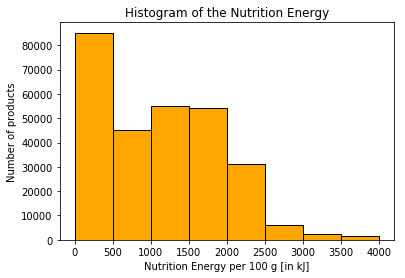

In [10]:
plt.hist(data['energy_100g'], bins = 500 * np.arange(9), color = 'orange', edgecolor = 'black')
plt.xlabel('Nutrition Energy per 100 g [in kJ]')
plt.ylabel('Number of products')
plt.title('Histogram of the Nutrition Energy')
plt.show()

In order to make some more interesting studies, we first try to make out the most commun ingredients in those products.

In [11]:
ingredients = pd.Series(data['ingredients_text'].values).str.lower().str.split()
ing = []
for i in range(ingredients.count()):
    for j in ingredients[i] :
        ing.append(j)
pd.Series(ing).value_counts()[:20]

de         378174
salt,       98603
:           97284
sugar,      83907
and         73728
organic     70481
water,      70421
oil,        61449
corn        61031
natural     60847
flour,      50273
sodium      50029
-           43250
acid,       41370
syrup,      39947
et          38975
milk,       38795
sel,        37579
citric      36008
wheat       34876
dtype: int64

This code provides us already a good idea of what the 5 most used ingredients are. However, it is not entirely reliable, because it assumes that 'oil' and 'oil,' are different ingredients. Moreover, the ingredients are written in at least two different languages (English and French). Another problem is that in the first entry of the data frame (the Banana Chips), the word oil appear multiple times and we only want to count it as once. Therefore, we need to contol the number of apparences of the ingredients by hand, using the informations above.

In [12]:
candidates_most_common_ing = ['sal|sel|chlorid|sodium', 'sugar|sucre|zucker|azúcar|azucar|zucchero', 
                              'water|eau|agua|aqua|wasser', 'oil|huile|öl|aceite|olio', 
                              'flour|farin|mehl|harina', 'corn|maïs|mai', 'milk|lait|milch|lecche|latte',
                              'acid|acido|ácido|saure|säure', 'wheat|blé|weizen|trigo|grano']
ingredients_candidates = ['salt', 'sugar', 'water', 'oil', 'flour', 'corn', 'milk', 'acid', 'wheat']
for i in range(len(candidates_most_common_ing)):
    print(ingredients_candidates[i], end = ' : ')
    print(data['ingredients_text'].str.lower().str.contains(candidates_most_common_ing[i]).sum())

salt : 159967
sugar : 120657
water : 106740
oil : 94255
flour : 62519
corn : 69151
milk : 72740
acid : 92350
wheat : 59749


This still may not be perfect (we considered English, French, Spanish, Italian and German), because there are other languages in the list. Also, maybe other ingredients contain the suffix 'eau' in their description without containing water. It gives us still a good idea what the 5 most common ingredients are (salt, sugar, water, oil and a type of acid) and corresponds to our intuition. 

# Data Analysis

We want to analyse the macronutritents breakdown of the articles containing those different products and see if they are correlated.

In [13]:
filter = data['ingredients_text'].str.contains(candidates_most_common_ing[0])== True
data_salt = data[filter]
filter = data['ingredients_text'].str.contains(candidates_most_common_ing[1])== True
data_sugar = data[filter]
filter = data['ingredients_text'].str.contains(candidates_most_common_ing[2])== True
data_water = data[filter]
filter = data['ingredients_text'].str.contains(candidates_most_common_ing[3])== True
data_oil = data[filter]
filter = data['ingredients_text'].str.contains(candidates_most_common_ing[7])== True
data_acid = data[filter]
filter = data['ingredients_text'].str.contains('milk|lait|milch|lecche|latte|butter|beurre|burro|mantequilla|cream|crème|creme|rahm|crema|cheese|fromage|formaggio|käse|kase|queso')== True
data_milk_products = data[filter]
filter = data['ingredients_text'].str.contains('flour|farin|mehl|harina|corn|maïs|mai|wheat|blé|weizen|trigo|grano') == True
data_cereal_products = data[filter]

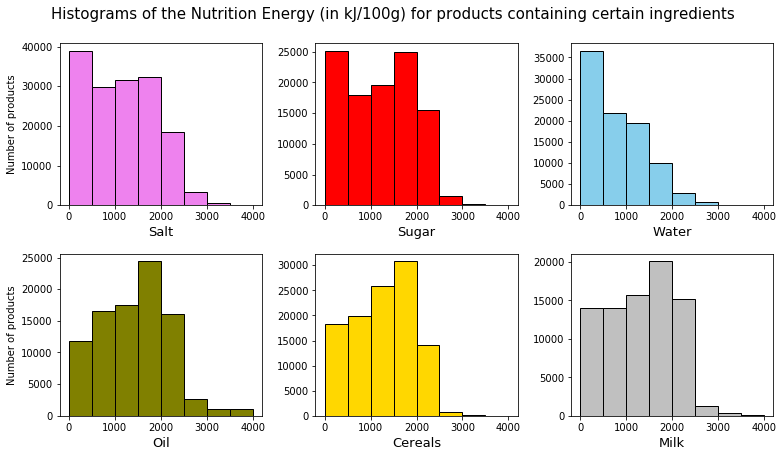

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 3, figsize = (11,6))
plt.xlabel('Nutrition Energy per 100 g [in kJ]')
ax1[0].hist(data_salt['energy_100g'], bins = 500 * np.arange(9), color = 'violet', edgecolor = 'black')
ax1[1].hist(data_sugar['energy_100g'], bins = 500 * np.arange(9), color = 'red', edgecolor = 'black')
ax1[2].hist(data_water['energy_100g'], bins = 500 * np.arange(9), color = 'skyblue', edgecolor = 'black')
ax2[0].hist(data_oil['energy_100g'], bins = 500 * np.arange(9), color = 'olive', edgecolor = 'black')
ax2[1].hist(data_cereal_products['energy_100g'], bins = 500 * np.arange(9), color = 'gold', edgecolor = 'black')
ax2[2].hist(data_milk_products['energy_100g'], bins = 500 * np.arange(9), color = 'silver', edgecolor = 'black')
ax1[0].set_ylabel('Number of products'), ax2[0].set_ylabel('Number of products')
ax1[0].set_xlabel('Salt', fontsize = 13), ax2[0].set_xlabel('Oil', fontsize = 13)
ax1[1].set_xlabel('Sugar', fontsize = 13), ax2[1].set_xlabel('Cereals', fontsize = 13)
ax1[2].set_xlabel('Water', fontsize = 13), ax2[2].set_xlabel('Milk', fontsize = 13)
plt.suptitle('Histograms of the Nutrition Energy (in kJ/100g) for products containing certain ingredients', 
             fontsize = 15).set_position([0.5, 1.05])
fig.tight_layout()
plt.show()

We see that the histogram of products containing salt is very similar to the general histogram we have seen above. It is not further surprising, because salt is contained in half of the products, does not contain macronutritents and is only present in small quantities. The other histograms are more interesting, because we see a clear correlation between the ingredients and the nutrition energy. 

Generally, a product containing water does not have a great nutrition energy. This can be explained that many products containing water are liquid and have great amounts of water in it. Since water does not contain macronutritents, the resulting nutrition energy is relatively small. In fact, even coke does not have a big nutrition energy (but the quantities we consume are far higher compared to other products).

We see also that products containing sugar or cereals do contain carbohydrates and therefore have greater amounts of nutrition energy. Similarily, products containing oil or milk do have generally a bigger amount of fats in it. Moreover, there are many 'unhealthy products' that combine these ingredients above, so it is not further surprising that its nutrition energies are greater. 

We will try to prove the assumptions above based on our intuition by computing the average values of the macronutritents contained in these products.



In [15]:
datas = [data, data_salt, data_sugar, data_water, data_oil, data_acid, data_cereal_products, data_milk_products]
fats = []
carbohydrates = []
proteins = []
nutrition = []
for dat in datas: 
    fats.append(dat[macronutritents].mean()[0]) 
    carbohydrates.append(dat[macronutritents].mean()[1]) 
    proteins.append(dat[macronutritents].mean()[2]) 
    nutrition.append(dat['energy_100g'].mean())
most_common_ingredients = ['General', 'Salt', 'Sugar', 'Water', 'Oil', 'Acid', 'Cereals', 'Milk']
macros = pd.DataFrame({'Products containing' : most_common_ingredients, 'Carbohydrates (in %)' : carbohydrates, 
                      'Fats (in %)' : fats, 'Proteins (in %)' : proteins, 'Nutrition Energy (in kJ)' : nutrition})
macros.set_index('Products containing', inplace = True)
macros = macros[['Nutrition Energy (in kJ)', 'Carbohydrates (in %)', 'Fats (in %)', 'Proteins (in %)']]
macros

,Nutrition Energy (in kJ),Carbohydrates (in %),Fats (in %),Proteins (in %)
Products containing,,,,
General,1121.541780,29.665424,11.986646,7.116726
Salt,1151.161898,29.535298,13.658400,8.324223
Sugar,1213.577694,38.447361,12.391873,6.055105
Water,814.288775,22.827135,8.630041,6.011560
Oil,1431.422810,38.820430,17.847938,6.870347
Acid,1037.688952,35.868574,9.042237,5.190440
Cereals,1266.750799,42.970591,11.366122,6.801750
Milk,1338.536079,33.099619,17.344371,7.964308


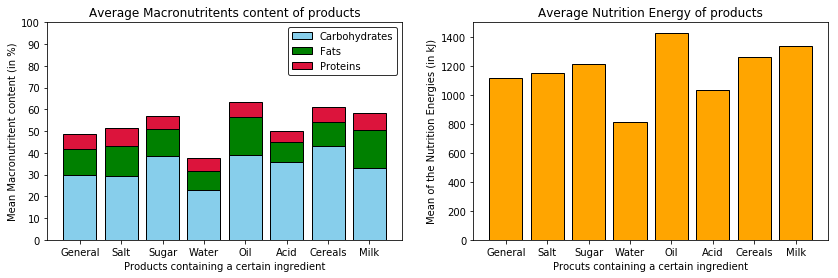

In [16]:
bottoms = np.array(fats) + np.array(carbohydrates)
fig, ax = plt.subplots(1, 2, figsize = (14,4), sharex = True)
ax[0].bar(np.arange(8), carbohydrates, edgecolor = 'black', label = 'Carbohydrates', color = 'skyblue')
ax[0].bar(np.arange(8), fats, edgecolor = 'black', label = 'Fats', bottom = carbohydrates, color = 'green')
ax[0].bar(np.arange(8), proteins, edgecolor = 'black', label = 'Proteins', bottom = bottoms, color = 'crimson')
ax[1].bar(np.arange(8), nutrition, edgecolor = 'black', color = 'orange')
ax[0].set_yticks(10*np.arange(11))
ax[0].set_xlabel('Products containing a certain ingredient')
ax[0].set_ylabel('Mean Macronutritent content (in %)')
ax[0].set_title('Average Macronutritents content of products')
ax[0].legend(loc = 'upper right', edgecolor = 'black')
ax[1].set_xlabel('Procuts containing a certain ingredient')
ax[1].set_ylabel('Mean of the Nutrition Energies (in kJ)')
ax[1].set_title('Average Nutrition Energy of products')
plt.xticks(np.arange(8), most_common_ingredients)
plt.show()

The first of the two barplots above shows the mean macronutritent content of the products containing a certain ingredient. This reflects the observations we saw while studying the histograms. Indeed, products containing oil or cereals have generally a greater macronutitent content than products containing water. 

We also see that products containing oil or milk have in general a greater amount of fats, whereas products containing sugar or cereals have greater amounts of carbohydrates. The amount of proteins seems balanced in the different categories. If you desire the exact amounts of mean macronutitent contents, you can refere to the data frame above.

We wanted to compare this barplot to the barplot showing the average nutrition energy of the products (on the right). We see that the two plots are very similar and indicates that the two plots are heavily correlated. We note that fats have a greater nutriment energy than carbohydrates and therefore the average nutrition energy of products containing milk is higher than the ones containing cereals, even though its macronutritent percentage is lower.

Our next objective is to prove that the macronutriments and the nutrition energy are indeed correlated.

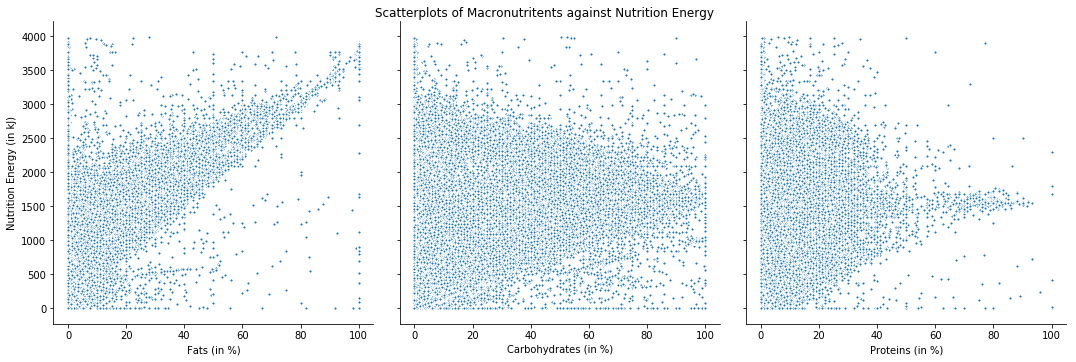

In [17]:
plot = sns.pairplot(data, x_vars = ['fat_100g', 'carbohydrates_100g', 'proteins_100g'], y_vars = 'energy_100g', 
             size = 5, plot_kws = {'s': 10})
ax = plot.axes.flatten()
ax[0].set_ylabel('Nutrition Energy (in kJ)')
ax[0].set_xlabel('Fats (in %)')
ax[1].set_xlabel('Carbohydrates (in %)')
ax[2].set_xlabel('Proteins (in %)')
plt.suptitle('Scatterplots of Macronutritents against Nutrition Energy').set_position([0.5, 1.0])
plt.show()

We made a scatterplots of fats and carbohydrates against the Nutrition Energy. There are many outliers (some due to the fact that we decided to set null values in the columns to zero), but we still see clear trents here. We see for example that if the percentage of fats is high, then the Nutrition Energy becomes higher as well. In fact, the products with the highest nutrition energy are oils and butter and both have big amounts of fats in it. 

In the case of the carbohydrates, we see that if the carbohydrate content augments, the nutrition energy augments, up to a certain point around 1600 kJ. In fact, the nutrition energy of sugar is 1700 kJ. However, the products with higher nutrition energy do contain less carbohydrates and probably more fats. The scatterplot is very similar in the case of proteins. This again shows that the fats have a greater energetic value than carbohydrates and proteins. 

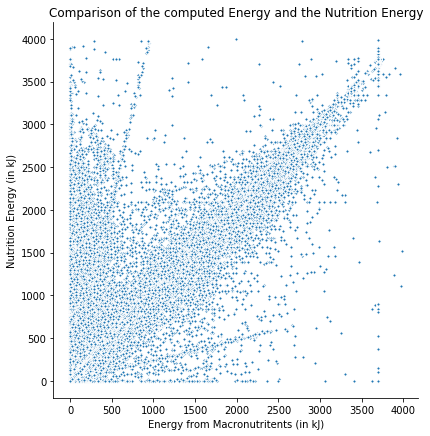

In [18]:
sum_macronutritents = 37 * data['fat_100g'] + 17 * data['carbohydrates_100g'] + 17 * data['proteins_100g']
data['Energy from Macronutritents (in kJ)'] = sum_macronutritents
filter = data['Energy from Macronutritents (in kJ)'] < 4000
plot = sns.pairplot(data[filter], x_vars = 'Energy from Macronutritents (in kJ)', y_vars = 'energy_100g', 
             size = 6, plot_kws = {'s': 10}) 
plot.set(ylabel='Nutrition Energy (in kJ)')
plt.title('Comparison of the computed Energy and the Nutrition Energy')
plt.show()

Using the fact that the Energy density of fats is 37 kJ/g and the Energy density of both carbohydrates and proteins is 17 kJ/g, we computed the energy that comes from those three macronutriments and compared it to the values of the data frame.

We see that the data is indeed heavily correlated. Of course, there are many outliers on the left hand side, probably due to missing or false values in the macronutriment columns. We also have to keep in mind that not all the nutrition energy of the products comes from those three macronutriments. For example, alcohol that has a big energetic value (but is present in only a few products) and organic acids, that we have seen are present in many products (but contributes less).

We note that most points lie near the diagonal, meaning that the values of the nutrition energy present in the data frame matches with most of the computed values using the quantities of macronutriments contained in 100g.

We analyse now the histograms of the nutrition energy by big retailers (mainly from Europe and the USA, because most of the data comes from there) and some famous food companies. The approach we used was quite similar as before and consisted first of identifying the most common words in the 'brands' column and then filtering the data that we found interesting. 

In [19]:
filter = data['brands'].str.lower().str.contains('nestlé') == True
data_nestlé = data[filter]
filter = data['brands'].str.lower().str.contains('kellogg') == True
data_kellogg = data[filter]
filter = data['brands'].str.lower().str.contains('auchan') == True
data_auchan = data[filter]
filter = data['brands'].str.lower().str.contains('meijer') == True
data_meijer = data[filter]
filter = data['brands'].str.lower().str.contains('carrefour') == True
data_carrefour = data[filter]
filter = data['brands'].str.lower().str.contains('kroger') == True
data_kroger = data[filter]
filter = data['brands'].str.lower().str.contains('casino') == True
data_wal = data[filter]
filter = data['brands'].str.lower().str.contains('migros') == True
data_migros = data[filter]
filter = data['brands'].str.lower().str.contains('ahold') == True
data_ahold = data[filter]
filter = data['brands'].str.lower().str.contains('spartan') == True
data_spartan = data[filter]
filter = data['brands'].str.lower().str.contains('wal-mart|walmart') == True
data_walmart = data[filter]
filter = data['brands'].str.lower().str.contains('lidl') == True
data_lidl = data[filter]
filter = data['brands'].str.lower().str.contains('lindt') == True
data_lindt = data[filter]
filter = data['brands'].str.lower().str.contains('unilever|knorr') == True
data_unilever = data[filter]
filter = data['brands'].str.lower().str.contains('mcdonald') == True
data_mcdo = data[filter]
filter = data['brands'].str.lower().str.contains('mondelez|kraft|heinz') == True
data_kraft = data[filter]

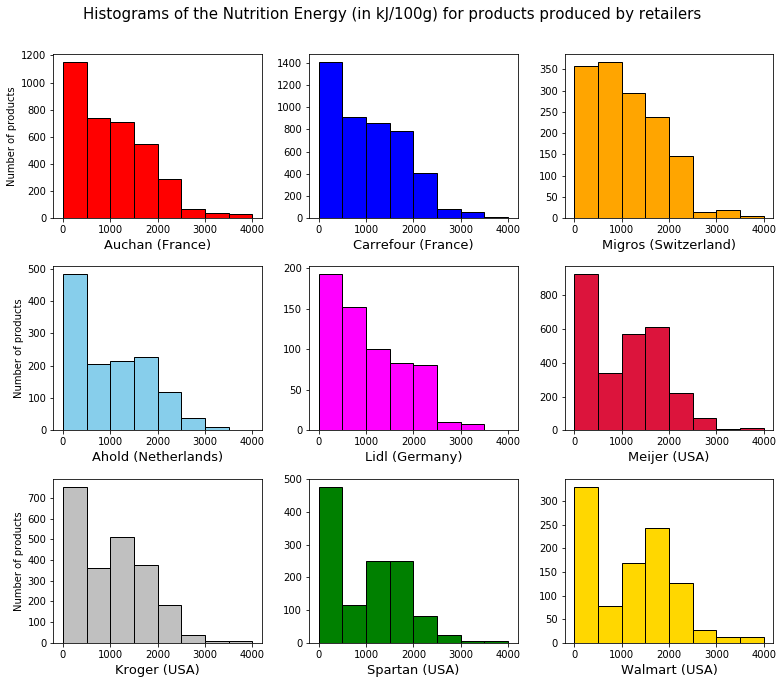

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize = (11,9))
plt.xlabel('Nutrition Energy per 100 g [in kJ]')
ax1[0].hist(data_auchan['energy_100g'], bins = 500 * np.arange(9), color = 'red', edgecolor = 'black')
ax1[1].hist(data_carrefour['energy_100g'], bins = 500 * np.arange(9), color = 'blue', edgecolor = 'black')
ax1[2].hist(data_migros['energy_100g'], bins = 500 * np.arange(9), color = 'orange', edgecolor = 'black')
ax2[0].hist(data_ahold['energy_100g'], bins = 500 * np.arange(9), color = 'skyblue', edgecolor = 'black')
ax2[1].hist(data_lidl['energy_100g'], bins = 500 * np.arange(9), color = 'magenta', edgecolor = 'black')
ax2[2].hist(data_meijer['energy_100g'], bins = 500 * np.arange(9), color = 'crimson', edgecolor = 'black')
ax3[0].hist(data_kroger['energy_100g'], bins = 500 * np.arange(9), color = 'silver', edgecolor = 'black')
ax3[1].hist(data_spartan['energy_100g'], bins = 500 * np.arange(9), color = 'green', edgecolor = 'black')
ax3[2].hist(data_walmart['energy_100g'], bins = 500 * np.arange(9), color = 'gold', edgecolor = 'black')
ax1[0].set_ylabel('Number of products'), ax2[0].set_ylabel('Number of products')
ax1[0].set_xlabel('Auchan (France)', fontsize = 13), ax2[0].set_xlabel('Ahold (Netherlands)', fontsize = 13)
ax1[1].set_xlabel('Carrefour (France)', fontsize = 13), ax2[2].set_xlabel('Meijer (USA)', fontsize = 13)
ax1[2].set_xlabel('Migros (Switzerland)', fontsize = 13), ax3[0].set_xlabel('Kroger (USA)', fontsize = 13)
ax3[1].set_xlabel('Spartan (USA)', fontsize = 13), ax3[2].set_xlabel('Walmart (USA)', fontsize = 13)
ax2[1].set_xlabel('Lidl (Germany)', fontsize = 13), ax3[0].set_ylabel('Number of products')
plt.suptitle('Histograms of the Nutrition Energy (in kJ/100g) for products produced by retailers', 
             fontsize = 15).set_position([0.5, 1.05])
fig.tight_layout()
plt.show()

Note that these data only correspond to the products produced by the retailer himself and not the food sold in the supermarket, nor the food consumed by the population. The trend is however clear : the product in the supermarket has a far greater energy content in the States than in Europe and could definitely explain the food habits. If the average product sold in a supermarket has a greater nutristic value, it is harder to live healthy.

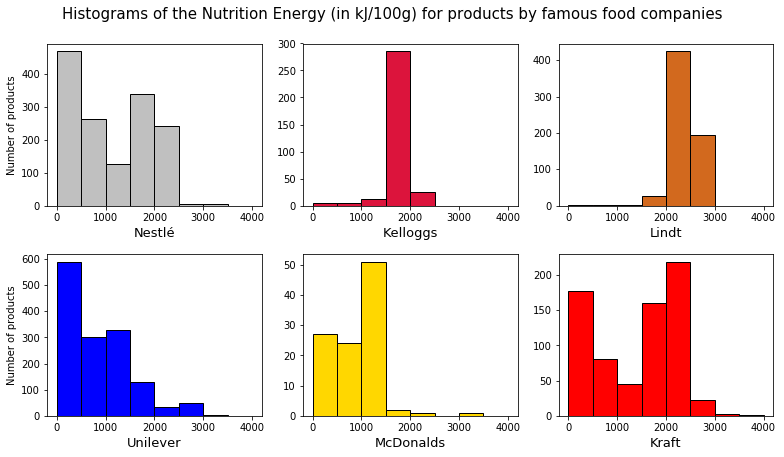

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 3, figsize = (11,6))
plt.xlabel('Nutrition Energy per 100 g [in kJ]')
ax1[0].hist(data_nestlé['energy_100g'], bins = 500 * np.arange(9), color = 'silver', edgecolor = 'black')
ax1[1].hist(data_kellogg['energy_100g'], bins = 500 * np.arange(9), color = 'crimson', edgecolor = 'black')
ax1[2].hist(data_lindt['energy_100g'], bins = 500 * np.arange(9), color = 'chocolate', edgecolor = 'black')
ax2[0].hist(data_unilever['energy_100g'], bins = 500 * np.arange(9), color = 'blue', edgecolor = 'black')
ax2[1].hist(data_mcdo['energy_100g'], bins = 500 * np.arange(9), color = 'gold', edgecolor = 'black')
ax2[2].hist(data_kraft['energy_100g'], bins = 500 * np.arange(9), color = 'red', edgecolor = 'black')
ax1[0].set_ylabel('Number of products'), ax2[0].set_ylabel('Number of products')
ax1[0].set_xlabel('Nestlé', fontsize = 13), ax2[0].set_xlabel('Unilever', fontsize = 13)
ax1[1].set_xlabel('Kelloggs', fontsize = 13), ax2[1].set_xlabel('McDonalds', fontsize = 13)
ax1[2].set_xlabel('Lindt', fontsize = 13), ax2[2].set_xlabel('Kraft', fontsize = 13)
plt.suptitle('Histograms of the Nutrition Energy (in kJ/100g) for products by famous food companies', 
             fontsize = 15).set_position([0.5, 1.05])
fig.tight_layout()
plt.show()

We see that big companies with many different brands like Nestlé, Kraft and Unilever have a brighter spectrum of nutrition energies (for example Nestlé specializes in water, coffee but also milk products and chocolate and those products have different energy levels). However, specialized brands like Kelloggs or Lindt have a big peak in the histogram, because most of its products are similar.

# Miscellaneous Tasks

We compute the mean time difference between the created datetime and the last modified datetime.

In [22]:
time_delta = pd.to_datetime(data['last_modified_datetime']) - pd.to_datetime(data['created_datetime'])
time_delta.mean()

Timedelta('107 days 10:15:29.836224')

We are now interested in knowing on which months the most items were added to the database.

In [23]:
created_time = pd.DataFrame(pd.to_datetime(data['created_datetime']))
created_time.set_index('created_datetime', inplace = True)
items_by_month = created_time.groupby(created_time.index.month).size()
items_by_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# The first entry was added the 31 January 2012 and the last in September 2017. We have therefore the
# entries of 5 years for January, October, November and December and entries of 6 years for the other months.
items_by_month['Jan', 'Oct', 'Nov', 'Dec'] = items_by_month / 5
items_by_month['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'] = items_by_month / 6

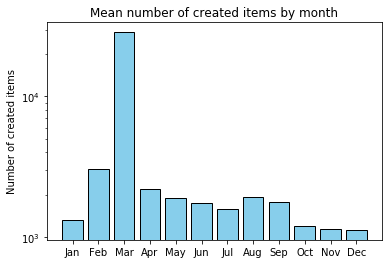

In [24]:
plt.bar(np.arange(12), items_by_month, edgecolor = 'black', color = 'skyblue')
plt.xticks(np.arange(12), items_by_month.index)
plt.yscale('log')
plt.title('Mean number of created items by month')
plt.ylabel('Number of created items')
plt.show()

We see that by far the most items were added to the database in March. We chose a logarithmic scale in order to see a difference between the other months. A lot of entries were added the 9th March 2017.

In [25]:
db = sqlite3.connect('food_database.db')
query = 'CREATE TABLE product (product_name TEXT PRIMARY KEY, created_datetime TEXT, brands TEXT, \
    countries_en TEXT, ingredients_text TEXT, energy_100g FLOAT);'
data_for_sql = data.iloc[0:1000, [0,2,3,4,5]]
data_for_sql.reset_index().to_sql(name = 'product', con = db, if_exists = 'append', index = False)

In [26]:
query = '''
SELECT * FROM product
ORDER BY energy_100g DESC
LIMIT 5;
''' # some fat products
pd.read_sql_query(query,db)

,product_name,created_datetime,brands,countries_en,ingredients_text,energy_100g
0,"Bunge, Clear Liquid Soybean Frying Oil",2017-03-09 17:04:19,Bunge Edible Oil Corporation,United States,Soybean oil with tbhq and citric acid added to...,3887.0
1,"Bunge, Clear Liquid Soybean Frying Oil",2017-03-09 17:04:19,Bunge Edible Oil Corporation,United States,Soybean oil with tbhq and citric acid added to...,3887.0
2,"Bunge, Clear Liquid Soybean Frying Oil",2017-03-09 17:04:19,Bunge Edible Oil Corporation,United States,Soybean oil with tbhq and citric acid added to...,3887.0
3,"Bunge, Clear Liquid Soybean Frying Oil",2017-03-09T17:04:19Z,Bunge Edible Oil Corporation,United States,Soybean oil with tbhq and citric acid added to...,3887.0
4,Organic Sunflower Oil,2017-03-09 10:34:14,Napa Valley Naturals,United States,"Organic expeller pressed, refined high oleic s...",3586.0


This gives us a functional data base, that could be used for further analysis. We already studied the correlations in the previous parts, where we studied the scatterplots of the different macronutritents.